In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rc('xtick', labelsize = 8) 
matplotlib.rc('ytick', labelsize = 8)

from gsw import SA_from_SP, p_from_z, CT_from_pt, rho
from gsw import rho
import xgcm
import cartopy.feature as cft

from sklearn import preprocessing
import xgcm
from xhistogram.xarray import histogram

import cartopy.mpl.ticker as cticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import matplotlib.patches as mpatches

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

import dask
dask.config.set({'logging.distributed': 'error'})

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43997,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:42583,Total threads: 4
Dashboard: /proxy/46071/status,Memory: 62.80 GiB
Nanny: tcp://127.0.0.1:33267,


In [4]:
db = '/scratch/x77/db6174/mom_old/archive/databases/025deg_jra55_ryf/cc_database_control_hh5.db'
session_cont = cc.database.create_session(db)

db = '/scratch/x77/db6174/mom_old/archive/databases/025deg_jra55_ryf/cc_database_heat_hh5.db'
session_heat = cc.database.create_session(db)

session = [session_cont, session_heat, session_heat]
expt = ['025deg_jra55_ryf_control', '025deg_jra55_ryf_fluxH_pos5W', '025deg_jra55_ryf_fluxH_pos10W']
name = ['Control', '+7.5 W m$^{-2}$', '+15 W m$^{-2}$']

## 1. Time-series and bar graphs

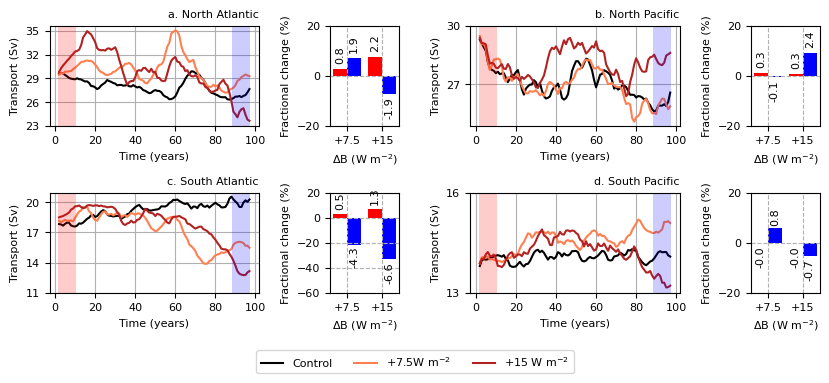

In [5]:
## Plotting attributes
name = ['a. North Atlantic', 'b. North Pacific', 'c. South Atlantic', 'd. South Pacific']
color_ts = ['Black', 'coral', 'firebrick']

## First 10 vs last 10 years are highlighted in red and blue
color_bar = ['red', 'blue']
st = [2,  87]
et = [12, 97]

## Bar graph attributes
color_bar = ['red', 'blue']
basin = ['NA', 'NP', 'SA', 'SP']
xlabels = ['-15', '-7.5']

# creating grid for subplots
fig = plt.figure()
fig.set_figheight(4*1.2)
fig.set_figwidth(7*1.2)

basin = ['NA', 'NP', 'SA', 'SP']
xlabels = ['+7.5', '+15']

lab = ['Control', '+7.5W m$^{-2}$', '+15 W m$^{-2}$']
for i, j in enumerate(basin):
    
    axes = plt.subplot2grid(shape=(3, 6), loc=(int(i/2), int(i%2)*3), colspan=2)
    psi = xr.open_dataset('NETCDF/Gyre_95th/' + j + '_STG/psi_iso95_pos_STG.nc')
    psi = psi.to_array().mean('variable')
    psi = psi[:, 0:3]
    #psi = xr.concat([psi[:, 0], psi[:, 2:]], 'expt')
    
    if(i == 0):
        if(j == 'NA'):
            for k in np.linspace(0, 2, 3):
                psi.isel(expt = int(k)).plot(ax = axes, color = color_ts[int(k)], label = lab[i])
        else:
            for k in np.linspace(0, 2, 3):
                (-1 * psi.isel(expt = int(k))).plot(ax = axes, color = color_ts[int(k)], label = lab[i])
    else:
        if(j == 'NA' or j == 'NP'):
            for k in np.linspace(0, 2, 3):
                psi.isel(expt = int(k)).plot(ax = axes, color = color_ts[int(k)])
        else:
            for k in np.linspace(0, 2, 3):
                (-1 * psi.isel(expt = int(k))).plot(ax = axes, color = color_ts[int(k)])
    
    if(i == 0):
        axes.set_yticks([23, 26, 29, 32, 35])
    elif(i == 1):
        axes.set_yticks([27, 30])
    elif(i == 2):
        axes.set_yticks([11, 14, 17, 20])
    elif(i == 3):
        axes.set_yticks([13, 16])
    axes.grid()
    axes.set_ylabel('Transport (Sv)', fontsize = 8)
    axes.set_xlabel('Time (years)', fontsize = 8)
    axes.set_title('')
    axes.set_title(name[i], fontsize = 8, loc='right')
    
    axes.axvline(x = 6, color = 'red', label = 'axvline - full height', alpha = 0.2, lw = 13)
    axes.axvline(x = 93, color = 'blue', label = 'axvline - full height', alpha = 0.2, lw = 13)
    
    axes = plt.subplot2grid(shape=(3, 6), loc=(int(i/2), 2 + int(i%2)*3), colspan=1)
    
    del_psi = (psi - psi.sel(expt = '025deg_jra55_ryf_control'))[:, 1:]
    del_perc = 100 * (psi/psi.sel(expt = '025deg_jra55_ryf_control') - 1)[:, 1:]
    
    xval = np.array([1, 2])

    for k in (xval-1):
        psi_vals = del_perc.sel(time = slice(st[k], et[k])).mean('time')
        plt.bar(xval - 0.2 + 0.4 * k, psi_vals, width = 0.4, color = color_bar[k])

        count = -1
        for l, m, x in zip(xval - 0.2 + 0.4 * k, psi_vals, psi_vals):
            count = count + 1
            
            if(i == 0):
                if(m > 0):
                    plt.text(l, m + 3, np.round(del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                             fontsize = 8, ha = 'center', rotation = 'vertical')
                else:
                    plt.text(l, m - 9, np.round(del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                             fontsize = 8, ha = 'center', rotation = 'vertical')
            if(i == 1):
                if(m > 0):
                    plt.text(l, m + 3, np.round(del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                             fontsize = 8, ha = 'center', rotation = 'vertical')
                else:
                    plt.text(l, m - 9, np.round(del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                             fontsize = 8, ha = 'center', rotation = 'vertical')
            elif(i == 2):
                if(count == 0):
                    if(m > 0):
                        plt.text(l, m + 5, np.round(-1 * del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                                 fontsize = 8, ha = 'center', rotation = 'vertical')
                    else:
                        plt.text(l, m - 17, np.round(-1 * del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                                 fontsize = 8, ha = 'center', rotation = 'vertical')
                elif(count == 1):
                    if(m > 0):
                        plt.text(l, m + 5, np.round(-1 * del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                                 fontsize = 8, ha = 'center', rotation = 'vertical')
                    else:
                        plt.text(l, m - 18, np.round(-1 * del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                                 fontsize = 8, ha = 'center', rotation = 'vertical')
            elif(i == 3):
                if(count == 0):
                    if(m > 0):
                        plt.text(l, m + 2, np.round(-1 * del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                                 fontsize = 8, ha = 'center', rotation = 'vertical')
                    else:
                        plt.text(l, m - 9, np.round(-1 * del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                                 fontsize = 8, ha = 'center', rotation = 'vertical')
                elif(count == 1):
                    if(m > 0):
                        plt.text(l, m - 9, np.round(-1 * del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                                 fontsize = 8, ha = 'center', rotation = 'vertical')
                    else:
                        plt.text(l, m - 9, np.round(-1 * del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                                 fontsize = 8, ha = 'center', rotation = 'vertical')
             
    #plt.subplots_adjust(wspace = 0a.3)
    axes.set_xticks(ticks = xval, labels = xlabels)
    axes.set_ylabel('Fractional change (%)', fontsize = 8)
    axes.set_xlabel('$\Delta$B (W m$^{-2}$)', fontsize = 8)
    if(i == 0):
        axes.set_yticks([-20, 0, 20])
    elif(i == 1):
        axes.set_yticks([-20, 0, 20])
    elif(i == 2):
        axes.set_yticks([-60, -40, -20, 0, 20])
    elif(i == 3):
        axes.set_yticks([-20, 0, 20])
    axes.grid(linestyle='--')
    axes.set_title('') 
    
fig.legend(lab, bbox_to_anchor = (0.5, 0.2), loc = 'lower center', ncol = 3, fontsize = 8)
plt.tight_layout()

#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Buoyancy_pos/Gyres_75_15.pdf', 
#            bbox_inches = 'tight', dpi = 900, transparent=True)

## 1b. Revised time-series and bar graphs

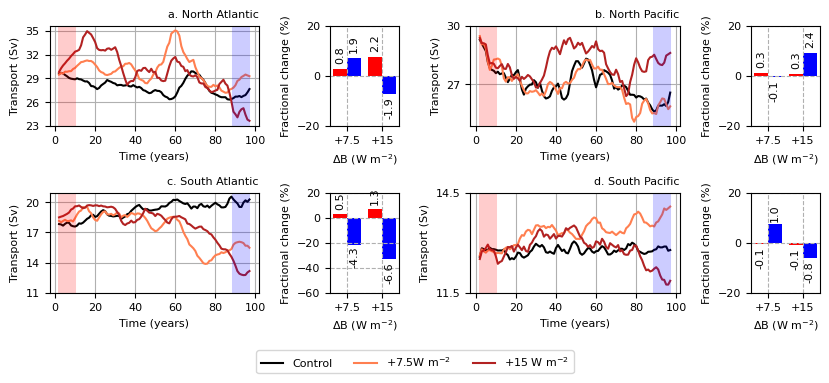

In [6]:
## Plotting attributes
name = ['a. North Atlantic', 'b. North Pacific', 'c. South Atlantic', 'd. South Pacific']
color_ts = ['Black', 'coral', 'firebrick']

## First 10 vs last 10 years are highlighted in red and blue
color_bar = ['red', 'blue']
st = [2,  87]
et = [12, 97]

## Bar graph attributes
color_bar = ['red', 'blue']
basin = ['NA', 'NP', 'SA', 'SP']
xlabels = ['-15', '-7.5']

# creating grid for subplots
fig = plt.figure()
fig.set_figheight(4*1.2)
fig.set_figwidth(7*1.2)

basin = ['NA', 'NP', 'SA', 'SP']
xlabels = ['+7.5', '+15']

lab = ['Control', '+7.5W m$^{-2}$', '+15 W m$^{-2}$']
for i, j in enumerate(basin):
    
    axes = plt.subplot2grid(shape=(3, 6), loc=(int(i/2), int(i%2)*3), colspan=2)
    if(i!=3):
        psi = xr.open_dataset('NETCDF/Gyre_95th/' + j + '_STG/psi_iso95_pos_STG.nc')
    elif(i == 3):
        psi = xr.open_dataset('NETCDF/Gyre_95th/SP_STG/psi_iso95_pos_AUNZ.nc')
    psi = psi.to_array().mean('variable')
    psi = psi[:, 0:3]
    #psi = xr.concat([psi[:, 0], psi[:, 2:]], 'expt')
    
    if(i == 0):
        if(j == 'NA'):
            for k in np.linspace(0, 2, 3):
                psi.isel(expt = int(k)).plot(ax = axes, color = color_ts[int(k)], label = lab[i])
        else:
            for k in np.linspace(0, 2, 3):
                (-1 * psi.isel(expt = int(k))).plot(ax = axes, color = color_ts[int(k)], label = lab[i])
    else:
        if(j == 'NA' or j == 'NP'):
            for k in np.linspace(0, 2, 3):
                psi.isel(expt = int(k)).plot(ax = axes, color = color_ts[int(k)])
        else:
            for k in np.linspace(0, 2, 3):
                (-1 * psi.isel(expt = int(k))).plot(ax = axes, color = color_ts[int(k)])
    
    if(i == 0):
        axes.set_yticks([23, 26, 29, 32, 35])
    elif(i == 1):
        axes.set_yticks([27, 30])
    elif(i == 2):
        axes.set_yticks([11, 14, 17, 20])
    elif(i == 3):
        axes.set_yticks([11.5, 14.5])
    axes.grid()
    axes.set_ylabel('Transport (Sv)', fontsize = 8)
    axes.set_xlabel('Time (years)', fontsize = 8)
    axes.set_title('')
    axes.set_title(name[i], fontsize = 8, loc='right')
    
    axes.axvline(x = 6, color = 'red', label = 'axvline - full height', alpha = 0.2, lw = 13)
    axes.axvline(x = 93, color = 'blue', label = 'axvline - full height', alpha = 0.2, lw = 13)
    
    axes = plt.subplot2grid(shape=(3, 6), loc=(int(i/2), 2 + int(i%2)*3), colspan=1)
    
    del_psi = (psi - psi.sel(expt = '025deg_jra55_ryf_control'))[:, 1:]
    del_perc = 100 * (psi/psi.sel(expt = '025deg_jra55_ryf_control') - 1)[:, 1:]
    
    xval = np.array([1, 2])

    for k in (xval-1):
        psi_vals = del_perc.sel(time = slice(st[k], et[k])).mean('time')
        plt.bar(xval - 0.2 + 0.4 * k, psi_vals, width = 0.4, color = color_bar[k])

        count = -1
        for l, m, x in zip(xval - 0.2 + 0.4 * k, psi_vals, psi_vals):
            count = count + 1
            
            if(i == 0):
                if(m > 0):
                    plt.text(l, m + 3, np.round(del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                             fontsize = 8, ha = 'center', rotation = 'vertical')
                else:
                    plt.text(l, m - 9, np.round(del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                             fontsize = 8, ha = 'center', rotation = 'vertical')
            if(i == 1):
                if(m > 0):
                    plt.text(l, m + 3, np.round(del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                             fontsize = 8, ha = 'center', rotation = 'vertical')
                else:
                    plt.text(l, m - 9, np.round(del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                             fontsize = 8, ha = 'center', rotation = 'vertical')
            elif(i == 2):
                if(count == 0):
                    if(m > 0):
                        plt.text(l, m + 5, np.round(-1 * del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                                 fontsize = 8, ha = 'center', rotation = 'vertical')
                    else:
                        plt.text(l, m - 17, np.round(-1 * del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                                 fontsize = 8, ha = 'center', rotation = 'vertical')
                elif(count == 1):
                    if(m > 0):
                        plt.text(l, m + 5, np.round(-1 * del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                                 fontsize = 8, ha = 'center', rotation = 'vertical')
                    else:
                        plt.text(l, m - 18, np.round(-1 * del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                                 fontsize = 8, ha = 'center', rotation = 'vertical')
            elif(i == 3):
                if(count == 0):
                    if(m > 0):
                        plt.text(l, m + 2, np.round(-1 * del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                                 fontsize = 8, ha = 'center', rotation = 'vertical')
                    else:
                        plt.text(l, m - 9, np.round(-1 * del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                                 fontsize = 8, ha = 'center', rotation = 'vertical')
                elif(count == 1):
                    if(m > 0):
                        plt.text(l, m - 9, np.round(-1 * del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                                 fontsize = 8, ha = 'center', rotation = 'vertical')
                    else:
                        plt.text(l, m - 9, np.round(-1 * del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), 
                                 fontsize = 8, ha = 'center', rotation = 'vertical')
             
    #plt.subplots_adjust(wspace = 0a.3)
    axes.set_xticks(ticks = xval, labels = xlabels)
    axes.set_ylabel('Fractional change (%)', fontsize = 8)
    axes.set_xlabel('$\Delta$B (W m$^{-2}$)', fontsize = 8)
    if(i == 0):
        axes.set_yticks([-20, 0, 20])
    elif(i == 1):
        axes.set_yticks([-20, 0, 20])
    elif(i == 2):
        axes.set_yticks([-60, -40, -20, 0, 20])
    elif(i == 3):
        axes.set_yticks([-20, 0, 20])
    axes.grid(linestyle='--')
    axes.set_title('') 
    
fig.legend(lab, bbox_to_anchor = (0.5, 0.2), loc = 'lower center', ncol = 3, fontsize = 8)
plt.tight_layout()

#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Buoyancy_pos/Gyres_75_15_revised.pdf', 
#            bbox_inches = 'tight', dpi = 900, transparent=True)

## 2. Abyssal gyre circulation

In [7]:
x_min, x_max, y_min, y_max = -100, 10, 20, 75
rho0 = 1036

T = cc.querying.getvar(expt = expt[0], session = session_cont, variable = 'temp', n = -1, use_cftime = True)
T = T.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)).mean('time')

area_t = cc.querying.getvar(expt = expt[0], session = session_cont, variable = 'area_t', n = -1)
area_t = area_t.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))

area_u = cc.querying.getvar(expt = expt[0], session = session_cont, variable = 'area_u', n = -1)
area_u = area_u.sel(xu_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))

geolon_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_t
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

SST = cc.querying.getvar(expt = expt[0], session = session_cont, variable = 'temp', frequency = '1 monthly', use_cftime = True)
SST = SST.isel(time = 0).isel(st_ocean = 0)

land = xr.where(np.isnan(SST.rename('land')), 1, np.nan)
land = land.assign_coords({'geolat_t': geolat_t, 'geolon_t': geolon_t})
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='papayawhip', linewidth=0.5)

### 2a. Abyssal gyre maps

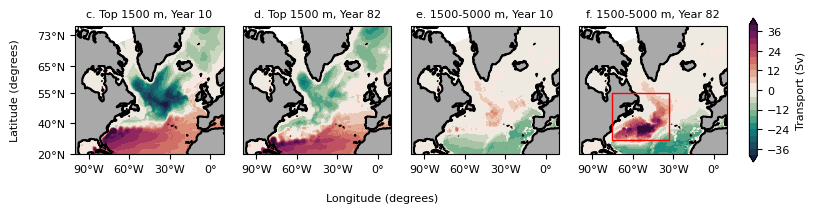

In [8]:
## plotting attributes
axis_extent = [x_min, x_max, y_min, y_max]
my_xticks = [-90, -60, -30, 0]
my_yticks = [20, 40, 55, 65, 73]
title_s = ['c. Top 1500 m, Year 10', 'd. Top 1500 m, Year 82']
title_b = ['e. 1500-5000 m, Year 10', 'f. 1500-5000 m, Year 82']

projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (6 * 1.2, 2 * 1.2), subplot_kw = {'projection': projection})

st = ['2204-01-01', '2276-01-01']
et = ['2212-12-31', '2284-12-31']

ty_trans_cont = cc.querying.getvar(expt = expt[0], session = session_cont, variable = 'ty_trans_int_z', frequency = '1 monthly', use_cftime = True)
ty_basin = ty_trans_cont.sel(xt_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))
psi_cont = ty_basin.cumsum('xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)

for co in np.arange(0, 2, 1):

    ty_trans = cc.querying.getvar(expt = expt[2], session = session_heat, variable = 'ty_trans',
                                  frequency = '1 monthly', use_cftime = True, start_time = st[co], end_time = et[co])
    ty_trans = ty_trans.sel(time = slice(st[co], et[co]))
    ty_basin = ty_trans.sel(xt_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))
    psi_basin = ty_basin.cumsum('xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)

    paths = []
    paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
    data = xr.merge((T, area_u, psi_basin))
    data.coords['xu_ocean'].attrs.update(axis='X')
    data.coords['xt_ocean'].attrs.update(axis='X', c_grid_axis_shift = 0.5)
    data.coords['yu_ocean'].attrs.update(axis='Y')
    data.coords['yt_ocean'].attrs.update(axis='Y', c_grid_axis_shift = 0.5)

    temp1 = xgcm.Grid(data, periodic = ['X'])
    psi_basin = temp1.interp(psi_basin, 'Y', boundary = "extend")

    psi_top = psi_basin.sel(st_ocean = slice(0,    1500)).sum('st_ocean')
    psi_bot = psi_basin.sel(st_ocean = slice(1500, 5000)).sum('st_ocean')

    psi_top = psi_top.assign_coords({'geolat_t': geolat_t, 'geolon_t': geolon_t})
    psi_bot = psi_bot.assign_coords({'geolat_t': geolat_t, 'geolon_t': geolon_t})

    p1 = psi_top.sel(time = slice(st[co], et[co])).mean('time').plot.contourf(x = 'geolon_t', y = 'geolat_t', ax = ax[co], levels = np.linspace(-40, 40, 21), 
                                                                       cmap = cm.cm.curl, add_colorbar = False, transform = ccrs.PlateCarree(), extend = 'both')
    psi_bot.sel(time = slice(st[co], et[co])).mean('time').plot.contourf(x = 'geolon_t', y = 'geolat_t', ax = ax[2*1 + co], levels = np.linspace(-40, 40, 21), 
                                                                       cmap = cm.cm.curl, add_colorbar = False, transform = ccrs.PlateCarree(), extend = 'both')

    if(co == 0):
        ax[co].set_yticks(my_yticks, crs=ccrs.PlateCarree())
    
    ax[co].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    ax[co].set_xticks(my_xticks, crs=ccrs.PlateCarree())
    ax[co].add_feature(land_50m, color=[1, 0, 0])
    ax[co].coastlines(resolution='50m')
    
    ax[co].xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax[co].yaxis.set_major_formatter(cticker.LatitudeFormatter())    
    ax[co].set_xlabel('')
    ax[co].set_ylabel('')
    
    ax[2+co].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    ax[2+co].set_xticks(my_xticks, crs=ccrs.PlateCarree())   
    ax[2+co].add_feature(land_50m, color=[1, 0, 0])
    ax[2+co].coastlines(resolution='50m')
    
    ax[2+co].xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax[2+co].yaxis.set_major_formatter(cticker.LatitudeFormatter())
    ax[2+co].set_xlabel('')
    ax[2+co].set_ylabel('')

    land.plot.contourf(ax = ax[co], x = 'geolon_t', y = 'geolat_t', colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar = False)
    land.plot.contourf(ax = ax[2*1 + co], x = 'geolon_t', y = 'geolat_t', colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar = False)
    # Coastline
    land.fillna(0).plot.contour(ax = ax[co], x = 'geolon_t', y = 'geolat_t', colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar = False)
    land.fillna(0).plot.contour(ax = ax[2*1 + co], x = 'geolon_t', y = 'geolat_t', colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar = False)

ax[3].add_patch(mpatches.Rectangle(xy=[-75, 30], width=42, height=25, facecolor=(1,0,0,0), edgecolor=(1,0,0,1), linewidth=1,
                                fill=True, zorder=2, transform=ccrs.PlateCarree()))

ax[0].set_ylabel('')
cax = plt.axes([1.01, 0.2, 0.011, 0.6])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = ax[1], extend = 'both')
cb.ax.set_ylabel('Transport (Sv)', fontsize = 8)

for l in np.arange(0, 2, 1):
    ax[l].set_title(title_s[l], fontsize = 8)
    ax[2+l].set_title(title_b[l], fontsize = 8)
    
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[3].set_xlabel('')

fig.text(0.5, 0.05, 'Longitude (degrees)', va = 'center', ha = 'center', rotation = 'horizontal', fontsize = 8)
fig.text(-0.01, 0.5, 'Latitude (degrees)', va = 'center', ha = 'center', rotation = 'vertical', fontsize = 8)
plt.tight_layout()

### 2b. Western boundary current, mixing layer depth and abyssal gyre strength time series

In [9]:
T_crop = T.sel(xt_ocean = slice(-80, -40)).sel(yt_ocean = slice(30, 45)).sel(st_ocean = 0, method = 'nearest')

area_t = cc.querying.getvar(expt = expt[0], variable = 'area_t', session = session[0], frequency = 'static', n = 1)
area_t = area_t.sel(xt_ocean = slice(-80, -40)).sel(yt_ocean = slice(30, 45))

area_u = cc.querying.getvar(expt = expt[0], variable = 'area_u', session = session[0], frequency = 'static', n = 1)
area_u = area_u.sel(xu_ocean = slice(-80, -40)).sel(yu_ocean = slice(30, 45))

area_t_basin = area_t.where(~np.isnan(T.sel(st_ocean = 0, method = 'nearest')))
area_t = area_t.rename('area_t')
area_u = area_u.rename('area_u')

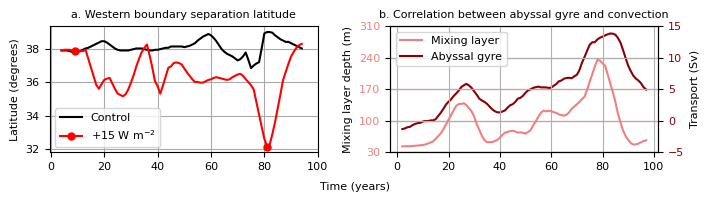

In [10]:
fig, ax1 = plt.subplots(nrows = 1, ncols = 2, figsize = (6 * 1.2, 1.6 * 1.2))
time = np.linspace(2, 97, 96)
ncoarse = 12

start_time = '2202-01-01'
end_time = '2301-12-31'

name_save = ['Control', 'Pos10W']

color1 = 'lightcoral'
color2 = 'darkred'
var_name = ['Mixing layer', 'Abyssal gyre']
label_cell = ['Control', '+15 W m$^{-2}$']

hblt = cc.querying.getvar('025deg_jra55_ryf_control', 'hblt', session = session_cont, start_time = start_time, end_time = end_time, use_cftime = True, frequency = '1 monthly')
hblt = hblt.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
hblt_cont = hblt.sel(xt_ocean = slice(-80, -40)).sel(yt_ocean = slice(30, 45))
hblt_cont = (hblt_cont * area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
hblt_cont = hblt_cont.coarsen({"time": ncoarse}, boundary = "trim").mean()

#color_val = ['dodgerblue', 'red']
color_ax0 = ['black', 'red']

for i, j in enumerate(expt[0:2]):
    
    ## First axes plotting begin
    ncfile = xr.open_dataset('NETCDF/WBC_Cutoff/' + name_save[i] + '.nc')
    data1 = ncfile.to_array().mean('variable')
    if(i == 0):
        data1.rolling(time = 5, center = True).mean().plot(ax = ax1[0], color = color_ax0[i], label = label_cell[i], markersize = 5)
    else:
        data1.rolling(time = 5, center = True).mean().plot(ax = ax1[0], color = color_ax0[i], markevery = [7, 79], 
                                                           label = label_cell[i], marker = 'o', mec = color_ax0[i], markersize = 5)
    
## Mixing layer depth for the deep gyre region
hblt = cc.querying.getvar(expt[2], 'hblt', session = session_heat, start_time = start_time, end_time = end_time, use_cftime = True, frequency = '1 monthly')
hblt = hblt.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
hblt = hblt.sel(xt_ocean = slice(-80, -40)).sel(yt_ocean = slice(30, 45))

## Streamfunction for the deep gyre region
ty_trans = cc.querying.getvar(expt[2], 'ty_trans', session = session_heat, start_time = start_time, end_time = end_time, use_cftime = True, frequency = '1 monthly')
ty_basin = ty_trans.sel(xt_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))
psi_basin = ty_basin.cumsum('xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)
psi_basin = psi_basin.where(~np.isnan(ty_trans.isel(time = 0)))
psi_basin = psi_basin.sel(st_ocean = slice(2000, 5000)).sum('st_ocean').sel(xt_ocean = slice(-80, -40)).sel(yu_ocean = slice(30, 45))

## Taking area-weighted average, and coarsening over time axis
hblt_avg = (hblt*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
hblt_avg = hblt_avg.coarsen({"time": ncoarse}, boundary = "trim").mean()

## Switching streamfunction plot from xt-yu to xt-yt grid
paths = []
paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
data = xr.merge((area_t, area_u, psi_basin))
data.coords['xu_ocean'].attrs.update(axis='X')
data.coords['xt_ocean'].attrs.update(axis='X', c_grid_axis_shift = 0.5)
data.coords['yu_ocean'].attrs.update(axis='Y')
data.coords['yt_ocean'].attrs.update(axis='Y', c_grid_axis_shift = 0.5)

temp1 = xgcm.Grid(data, periodic = ['X'])
psi_basin = temp1.interp(psi_basin, 'Y', boundary = "extend")

## Taking area-weighted average, and coarsening over time axis
psi_avg = (psi_basin*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
psi_avg = psi_avg.coarsen({"time": ncoarse}, boundary = "trim").mean()
p1 = ax1[1].plot(time, hblt_avg.rolling(time = 5, center = True).mean().dropna("time"), color = color1, label = var_name[0])
ax1[1].tick_params(axis='y', labelcolor=color1)
    
ax2 = ax1[1].twinx()  # instantiate a second axes that shares the same x-axis
p2 = ax2.plot(time, psi_avg.rolling(time = 5, center = True).mean().dropna("time"), color = color2, label = var_name[1])
ax2.tick_params(axis='y', labelcolor=color2)
    
lns = p1+p2
labs = [l.get_label() for l in lns]
ax1[1].legend(lns, var_name, fontsize = 8, loc = 'upper left')

ax1[0].set_xticks([0, 20, 40, 60, 80, 100])
ax1[1].set_yticks([30, 100, 170, 240, 310])
ax2.set_yticks([-5, 0, 5, 10, 15])
ax2.grid(color = color2)

for ax in ([ax1[1], ax2]):
    #ax.set_ylim(0, ylim)
    ax.grid(True)

ax1[1].set_zorder(1)
ax1[1].patch.set_alpha(0)
ax2.set_zorder(0)

ax1[0].legend(fontsize = 8, loc = 'lower left')
ax1[0].grid(color = 'darkgray')
ax1[0].set_xlabel('')
ax1[0].set_ylabel('Latitude (degrees)', fontsize = 8)
ax1[0].set_title('a. Western boundary separation latitude', fontsize = 8)

ax1[1].set_ylabel('Mixing layer depth (m)', fontsize = 8)
ax2.set_ylabel('Transport (Sv)', fontsize = 8)
ax1[1].set_title('b. Correlation between abyssal gyre and convection', fontsize = 8)

fig.text(0.5, 0.0, 'Time (years)', va = 'center', ha = 'center', rotation = 'horizontal', fontsize = 8)
plt.tight_layout()
#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Buoyancy_pos/NA_hlbt_deepgyre_15W.pdf', bbox_inches = 'tight', dpi = 900, transparent=True)

## 3. Atlantic basin buoyancy anomaly plots

In [11]:
start_time = '2202-01-01'
end_time = '2301-12-31'

st = ['2204-12-31', '2247-01-01', '2292-01-01']
et = ['2213-12-31', '2256-12-31', '2301-12-31']

expt_cell = ['025deg_jra55_ryf_fluxH_pos5W', '025deg_jra55_ryf_fluxH_pos10W']

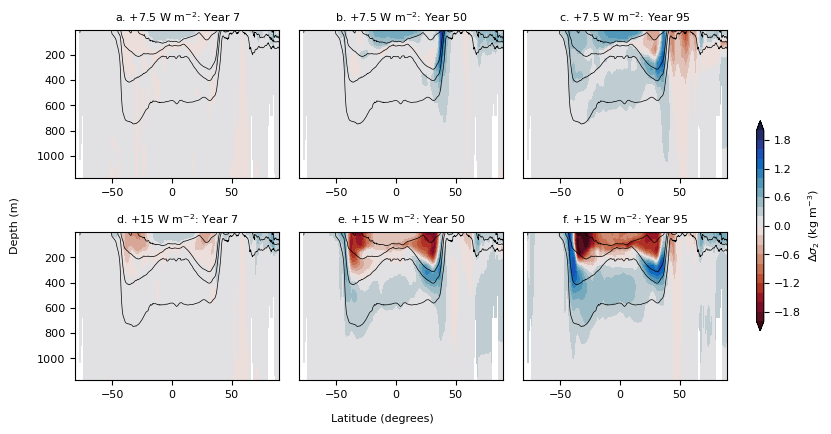

In [12]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (6 * 1.2, 3.5 * 1.2))

pcont = cc.querying.getvar(expt[0], 'pot_rho_2',session = session[0], start_time = start_time, end_time = end_time, use_cftime = True) - 1000
pcont_c = pcont.sel(time = slice(start_time, end_time)).mean('time')

for i, j in enumerate(expt_cell):
    if(i == 0):
        name_save = ['a. +7.5 W m$^{-2}$: Year 7', 'b. +7.5 W m$^{-2}$: Year 50', 'c. +7.5 W m$^{-2}$: Year 95']
    else:
        name_save = ['d. +15 W m$^{-2}$: Year 7', 'e. +15 W m$^{-2}$: Year 50', 'f. +15 W m$^{-2}$: Year 95']
    for k in np.arange(0, len(st), 1):
        
        potrho = cc.querying.getvar(expt_cell[i], 'pot_rho_2',session = session_heat, start_time = st[k], end_time = et[k], use_cftime = True) - 1000
        potrho = potrho.sel(time = slice(st[k], et[k]))
        pcont_c.sel(xt_ocean = slice(-60, -30)).mean('xt_ocean').sel(st_ocean = slice(0, 1200)).plot.contour(levels = [26, 32, 34, 35, 36], cmap = 'Black', linewidths = 0.5, ax = ax[i][k])
        
        pcont_cf = pcont.sel(time = slice(st[k], et[k]))
        p1 = (potrho - pcont_cf).mean('time').sel(xt_ocean = slice(-60, -30)).mean('xt_ocean').sel(st_ocean = slice(0, 1200)).plot.contourf(cmap = cm.cm.balance_r, levels = np.linspace(-2, 2, 21), ax = ax[i][k], add_colorbar = False, extend = 'both')
        ax[i][k].invert_yaxis()
        ax[i][k].set_xlabel('')
        ax[i][k].set_ylabel('')
        ax[i][k].set_title(name_save[k], fontsize = 8)
        
        if(k!=0):
            ax[i][k].set_yticks([])
        
cax = plt.axes([1.02, 0.2, 0.01, 0.5])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', extend = 'both')
cb.set_label('$\Delta \sigma_2$ (kg m$^{-3}$)', fontsize = 8)
fig.text(0.5, -0.01, 'Latitude (degrees)', va = 'center', ha = 'center', rotation = 'horizontal', fontsize = 8)
fig.text(-0.01, 0.45, 'Depth (m)', va = 'center', ha = 'center', rotation = 'vertical', fontsize = 8)
plt.tight_layout()

#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Buoyancy_pos/Stratification_anomalies_Atlantic_only2.pdf', bbox_inches = 'tight', dpi = 300, transparent=True)

## 4. Pacific basin buoyancy anomaly plots

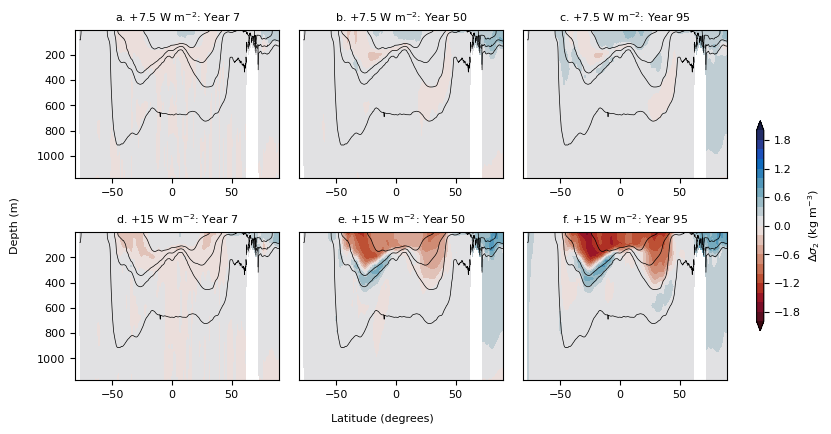

In [13]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (6 * 1.2, 3.5 * 1.2))

pcont = cc.querying.getvar(expt[0], 'pot_rho_2',session = session[0], start_time = start_time, end_time = end_time, use_cftime = True) - 1000
pcont_c = pcont.sel(time = slice(start_time, end_time)).mean('time')

for i, j in enumerate(expt_cell):
    if(i == 0):
        name_save = ['a. +7.5 W m$^{-2}$: Year 7', 'b. +7.5 W m$^{-2}$: Year 50', 'c. +7.5 W m$^{-2}$: Year 95']
    else:
        name_save = ['d. +15 W m$^{-2}$: Year 7', 'e. +15 W m$^{-2}$: Year 50', 'f. +15 W m$^{-2}$: Year 95']
    for k in np.arange(0, len(st), 1):
        
        potrho = cc.querying.getvar(expt_cell[i], 'pot_rho_2',session = session_heat, start_time = st[k], end_time = et[k], use_cftime = True) - 1000
        potrho = potrho.sel(time = slice(st[k], et[k]))
        pcont_c.sel(xt_ocean = slice(-220, -140)).mean('xt_ocean').sel(st_ocean = slice(0, 1200)).plot.contour(levels = [26, 32, 34, 35, 36], cmap = 'Black', linewidths = 0.5, ax = ax[i][k])
        
        pcont_cf = pcont.sel(time = slice(st[k], et[k]))
        p1 = (potrho - pcont_cf).mean('time').sel(xt_ocean = slice(-220, -140)).mean('xt_ocean').sel(st_ocean = slice(0, 1200)).plot.contourf(cmap = cm.cm.balance_r, levels = np.linspace(-2, 2, 21), ax = ax[i][k], add_colorbar = False, extend = 'both')
        ax[i][k].invert_yaxis()
        ax[i][k].set_xlabel('')
        ax[i][k].set_ylabel('')
        ax[i][k].set_title(name_save[k], fontsize = 8)
        
        if(k!=0):
            ax[i][k].set_yticks([])
        
cax = plt.axes([1.02, 0.2, 0.01, 0.5])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', extend = 'both')
cb.set_label('$\Delta \sigma_2$ (kg m$^{-3}$)', fontsize = 8)
fig.text(0.5, -0.01, 'Latitude (degrees)', va = 'center', ha = 'center', rotation = 'horizontal', fontsize = 8)
fig.text(-0.01, 0.45, 'Depth (m)', va = 'center', ha = 'center', rotation = 'vertical', fontsize = 8)
        
plt.tight_layout()

#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Buoyancy_pos/Stratification_anomalies_Pacific_only2.pdf', bbox_inches = 'tight', dpi = 300, transparent=True)

## 5. Large-scale circulation plots

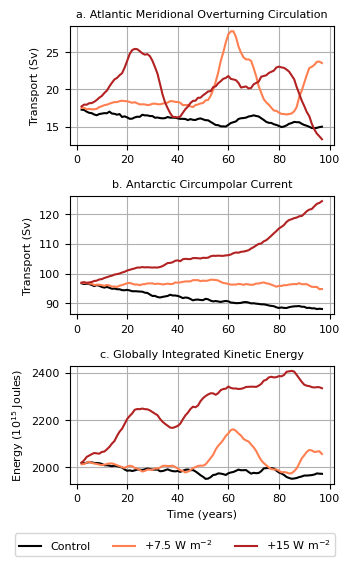

In [14]:
time_val = np.linspace(0 + 2, 95 + 2, 96)
lab = ['Control', '+7.5 W m$^{-2}$', '+15 W m$^{-2}$']
color_ts = ['Black', 'coral', 'firebrick']
rho0 = 1036

fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (3*1.2, 4.5*1.2))

for i, j in enumerate(session):
    
    ## Plotting AMOC
    psi_amoc = cc.querying.getvar(expt[i], 'ty_trans_rho', session = session[i], use_cftime = True, start_time = start_time, end_time = end_time).sel(
        grid_xt_ocean = slice(-103, -5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26)*1.0e-9
    psi_amoc = psi_amoc.sel(time = slice(start_time, end_time))
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho = slice(1035.5, None)).max('potrho').resample(time = 'Y').mean()
    axes[0].plot(time_val, psi_amoc_sum.rolling(time = 5, center = True).mean().dropna("time"), label = lab[i], color = color_ts[i])
    axes[0].set_xlabel('', fontsize = 8)
    axes[0].set_ylabel('Transport (Sv)', fontsize = 8)
    axes[0].set_title('a. Atlantic Meridional Overturning Circulation', fontsize = 8)

    ## Plotting DP Transport
    xmin, ymin, ymax = -69.9, -71.6, -51.0
    DP_trans = cc.querying.getvar(expt[i], 'tx_trans_int_z', session = session[i], use_cftime = True).sel(
        xu_ocean = xmin, method='nearest').sel(yt_ocean = slice(ymin, ymax)).sum('yt_ocean')/rho0/1e6
    DP_trans = DP_trans.sel(time = slice(start_time, end_time))
    DP_trans = DP_trans.coarsen({"time": 12}, boundary = "trim").mean()
    axes[1].plot(time_val, DP_trans.rolling(time = 5, center = True).mean().dropna("time"), color = color_ts[i])
    axes[1].set_xlabel('', fontsize = 8)
    axes[1].set_ylabel('Transport (Sv)', fontsize = 8)
    axes[1].set_title('b. Antarctic Circumpolar Current', fontsize = 8)
    
    ## Plotting globally integrated KE
    ke = cc.querying.getvar(expt = expt[i], session = session[i], variable = 'ke_tot', use_cftime = True)
    ke = ke.sel(time = slice(start_time, end_time))
    ke = ke.coarsen({"time": 364}, boundary = "trim").mean()
    axes[2].plot(time_val, ke.rolling(time = 5, center = True).mean().dropna("time"), color = color_ts[i])
    axes[2].set_xlabel('Time (years)', fontsize = 8)
    axes[2].set_ylabel('Energy ($10^{15}$ Joules)', fontsize = 8)
    axes[2].set_title('c. Globally Integrated Kinetic Energy', fontsize = 8)
    
axes[0].grid()
axes[1].grid()
axes[2].grid()
    
fig.legend(bbox_to_anchor = (0.5, -0.05), loc = 'lower center', ncol = 3, fontsize = 8)
plt.tight_layout()
#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Buoyancy_pos/MOC_exceptAABW.pdf', bbox_inches = 'tight', dpi = 300, transparent=True)

## 5b. Presenting for reviewers

In [15]:
session = [session_cont, session_heat, session_heat, session_heat]
expt = ['025deg_jra55_ryf_control', '025deg_jra55_ryf_fluxH_pos5W', '025deg_jra55_ryf_fluxH_pos10W', '025deg_jra55_ryf_fluxH_pos20W']
name = ['Control', '+7.5 W m$^{-2}$', '+15 W m$^{-2}$', '+30 W m$^{-2}$']

ncoarse = 12

start_time = '2202-01-01'
end_time = '2301-12-31'

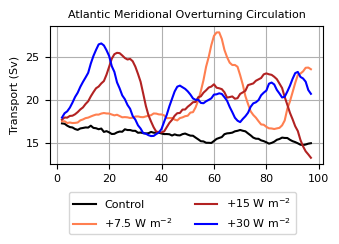

In [16]:
time_val = np.linspace(0 + 2, 95 + 2, 96)
lab = ['Control', '+7.5 W m$^{-2}$', '+15 W m$^{-2}$', '+30 W m$^{-2}$']
color_ts = ['Black', 'coral', 'firebrick', 'blue']
rho0 = 1036

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (3*1.2, 1.7*1.2))

for i, j in enumerate(session):
    ## Plotting AMOC
    psi_amoc = cc.querying.getvar(expt[i], 'ty_trans_rho', session = session[i], use_cftime = True, start_time = start_time, end_time = end_time).sel(
        grid_xt_ocean = slice(-103, -5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26)*1.0e-9
    psi_amoc = psi_amoc.sel(time = slice(start_time, end_time))
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho = slice(1035.5, None)).max('potrho').resample(time = 'Y').mean()
    axes.plot(time_val, psi_amoc_sum.rolling(time = 5, center = True).mean().dropna("time"), label = lab[i], color = color_ts[i])
    axes.set_xlabel('', fontsize = 8)
    axes.set_ylabel('Transport (Sv)', fontsize = 8)
    axes.set_title('Atlantic Meridional Overturning Circulation', fontsize = 8)
    
axes.grid()
fig.legend(bbox_to_anchor = (0.55, -0.2), loc = 'lower center', ncol = 2, fontsize = 8)
plt.tight_layout()
#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Buoyancy_pos/AMOC_reviewers.pdf', bbox_inches = 'tight', dpi = 300, transparent=True)